# Метрики качества классификации

## 1. Данные

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X = pd.read_pickle('data/shelter/xtrain.pkl')
y = pd.read_csv('data/shelter/train.csv')['OutcomeType']

для учебных примеров оставим только 2 класса, отличающихся значительно и по смыслу, и по размеру

In [5]:
y.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [6]:
is_first_2_class = (y=='Adoption')|(y=='Euthanasia')

In [7]:
X = X[is_first_2_class]
X.index = range(len(X))
y = y[is_first_2_class]
y.index = range(len(y))

y теперь можно перевести в множество {0,1}

In [8]:
y = (y=='Adoption').astype(int)

для оценки качества разобьём выборки на 2 части, 3:1

In [9]:
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.25)

-----

## 2. Обучим классификатор

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
clf = DecisionTreeClassifier(max_depth=5)

In [12]:
clf.fit(Xtr, ytr)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
yval_pred = clf.predict(Xval)
yval_pred_proba = clf.predict_proba(Xval)

-----

## 3. Написание метрик с нуля

In [14]:
from sklearn import metrics

-----

In [15]:
metrics.confusion_matrix(yval, yval_pred)

array([[ 236,  168],
       [  18, 2659]], dtype=int64)

In [16]:
metrics.accuracy_score(yval, yval_pred)

0.9396299902629016

In [17]:
metrics.precision_score(yval, yval_pred)

0.9405730456314114

In [18]:
metrics.recall_score(yval, yval_pred)

0.9932760552857677

In [19]:
metrics.roc_auc_score(yval, yval_pred_proba[:,1])

0.9200089134800667

In [20]:
metrics.average_precision_score(yval, yval_pred_proba[:,1])

0.9802711314952787

## Реализовать самостоятельно вывод графика ROC-AUC

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

In [158]:
def calculate_tpr_and_fpr(y_true, y_pred_probas, alpha):
    ## 1. Отнесите  наблюдения к одному  из нескольких классов в зависимости от порога
    TP = 0
    FN = 0
    FP = 0
    TN = 0
    for i, y_t in enumerate(y_true):
        if ((y_t == 1) and (y_pred_probas[i] >= alpha)):
            TP += 1
        else:
            FN += 1
        if ((y_t == 0) and (y_pred_probas[i] >= alpha)):
            FP += 1
        else:
            TN += 1
    ## 2. Посчитайте tpr и fpr
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    #print(fpr, tpr)
    return tpr, fpr        

In [159]:
def roc_auc_plot(y_true, y_pred_probas):
    alphas = np.arange(0, 1, 0.001)
    tprs, fprs = [], []
    for a in alphas:
        tpr, fpr = calculate_tpr_and_fpr(y_true, y_pred_probas, a)
        tprs.append(tpr)
        fprs.append(fpr)
        
    plt.plot(fprs, tprs)
    plt.show()

In [148]:
yval.shape

(3081,)

In [149]:
yval

6415     1
3049     0
3131     0
10101    1
7734     1
        ..
9875     1
4572     1
6866     0
7960     1
4769     0
Name: OutcomeType, Length: 3081, dtype: int32

In [150]:
yval_pred_proba.shape

(3081, 2)

In [151]:
yval_pred_proba

array([[0.08188908, 0.91811092],
       [1.        , 0.        ],
       [0.2       , 0.8       ],
       ...,
       [0.2375    , 0.7625    ],
       [0.03127506, 0.96872494],
       [1.        , 0.        ]])

In [50]:
?metrics.roc_curve

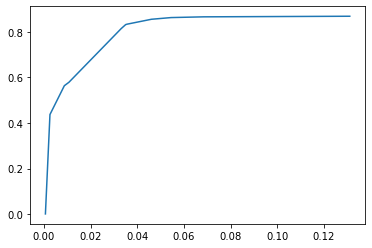

In [160]:
roc_auc_plot(yval, yval_pred_proba[:, 1])

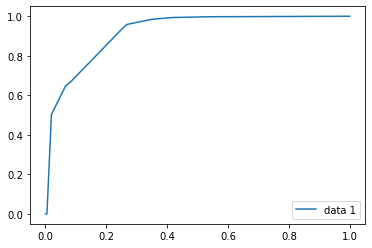

In [156]:
## SKLEARN
fpr, tpr, _ = metrics.roc_curve(yval,  yval_pred_proba[: ,1])
plt.plot(fpr,tpr,label="data 1")
plt.legend(loc=4)
plt.show()